# Guess the Tech - Identifying Bias in 16S Library Construction

## Shane Roesemann
## Python for Data Science, CSCI E-29
## Harvard University


#### Background

I work in a microbiology lab that investigates the microbiome.  This process involves extracting DNA from a biological sample (usually stool), preparing this DNA in a process called Library Construction, sequencing the prepared DNA (called libraries), and analyzing the output.

This output comes in a compressed raw form.  This raw data is processed extensively in a process I will not describe here.  But the output to be used for analysis is called an OTU table.  An OTU, or 'Operational Taxonomic Unit' is an intentionally vague lable that identifies the bacterial composition of the sample.  This can be as specific strain of Escherichia coli, just the genus Klebsiella, or an unknown bacteria which it will lable with a number (ex. OTU 100939).  An OTU table is a representation of the abundance of each OTU for each sample.

These tables are then used to calculate alpha diversity (the diversity within one sample) and the beta diversity (diversity between samples).  In this exercise, we will be looking at the diversity between samples, specifically using a metric of dissimilarity called the Bray-Curtis dissimilarity index.


#### The Experiment

Our lab recently hired a new person and we wanted to validate that this person can make libraries accurately.  To demonstrate this, we took 9 samples and gave them to the new person (new guy) and an experienced tech (referred to as old guy). Each tech brought the samples through library construction and the samples were sequenced, the data was processed, and OTU tables were generated.

#### Analysis Methodology

I will try to identify if the samples will cluster more strongly by sample or by tech.  If the samples cluster by tech then we know the new guy introduced some bias to the data compared to the validated old guy.  If the samples cluster by samples (ex: sample 6_new_guy looks the most similar to sample 6_old_guy) then the library construction process is impervious to bias, we all get grants and nobel prizes and we all go to disneyworld.


### Imports

In [442]:
# Package Imports

import pandas as pd
import matplotlib.pylab as plt

import skbio
from skbio.diversity import beta_diversity
from skbio.stats.distance import permanova

import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [281]:

# Import data from NEW guy
new_data = pd.DataFrame.from_csv("/Users/shane/Documents/thom_validation/444_data.csv")

# Import data from OLD guy
old_data = pd.DataFrame.from_csv("/Users/shane/Documents/thom_validation/417_data.csv")

In [282]:
df = new_data.merge(old_data, how='outer', left_index=True, right_index=True)

df.head()

,S1_NEW,S4_NEW,S5_NEW,S3_NEW,PCR_control_1_NEW,PCR_control_2_NEW,PCR_control_3_NEW,S2_NEW,S6_NEW,taxonomy_x,PCR_control_2_OLD,S1_OLD,S6_OLD,PCR_control_3_OLD,PCR_contro_1_OLD,S3_OLD,S2_OLD,S5_OLD,S4_OLD,taxonomy_y
OTU,,,,,,,,,,,,,,,,,,,,
1007750,70.0,53.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.0,30.0,1.0,0.0,0.0,0.0,1.0,1.0,21.0,k__Bacteria; p__Firmicutes; c__Clostridia; o__...
1010876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Firmicutes; c__Clostridia; o__...
1019594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Firmicutes; c__Clostridia; o__...
1028036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bac...


### Finagle the df (nans, transform , remove unnecessary columns)

In [283]:
# transform df so OTUs are column headers and samples are rows

df = df.T

In [284]:
# fill nans with 0's
df = df.fillna(0)


In [285]:
# Remove Taxonomic information
df = df.drop(['taxonomy_x', 'taxonomy_y'], axis = 0)

In [286]:
df.head()

OTU,1007750,1010876,1019594,102424,1028036,1029165,1033687,1040172,1040713,1040889,...,OTU990,OTU991,OTU992,OTU993,OTU994,OTU995,OTU996,OTU997,OTU998,OTU999
S1_NEW,70,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
S4_NEW,53,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
S5_NEW,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
S3_NEW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PCR_control_1_NEW,0,0,0,0,0,0,0,0,0,163,...,0,0,0,0,0,0,0,0,0,0


In [287]:
# strip the df of index and column names, save them to variables
print(df.shape)

ids = df.index
otu_ids = df.columns
print('These are OTU IDs', otu_ids)


(18, 4884)
These are OTU IDs Index(['1007750', '1010876', '1019594', '102424', '1028036', '1029165',
       '1033687', '1040172', '1040713', '1040889',
       ...
       'OTU990', 'OTU991', 'OTU992', 'OTU993', 'OTU994', 'OTU995', 'OTU996',
       'OTU997', 'OTU998', 'OTU999'],
      dtype='object', name='OTU', length=4884)


In [289]:
# strip the df so it is only an array of raw counts
df_bare = pd.DataFrame.as_matrix(df).astype('int64')

In [290]:
# Make an array of tech lables
techs = ['New Guy'] *9
techs.extend(['Old Guy'] * 9)

# array of sample ids
sample_id = ['S1', 'S4', 'S5', 'S3', 'Control', 'Control', 
            'Control', 'S2', 'S6', 'Control', 'S1', 'S6', 
             'Control', 'Control', 'S3', 'S2', 'S5', 'S4']

# convert this to colors for graphing
sample_id_map = {'S1': 'red', 'S4': 'blue', 'S3': 'yellow',
                 'Control': 'brown', 'S2': 'purple', 'S5': 'orange',
                'S6': 'green'}


# array of tech id colors
sample_name_colors = ['Green'] * 9
sample_name_colors.extend(['Blue'] * 9)




df_meta = pd.DataFrame()
df_meta['Tech'] = techs
df_meta['Sample Name'] = ids
df_meta['Sample ID'] = sample_id
df_meta['Sample Name Colors'] = sample_name_colors
df_meta['Sample ID Colors'] = df_meta['Sample ID'].map(sample_id_map)

df_meta

,Tech,Sample Name,Sample ID,Sample Name Colors,Sample ID Colors
0,New Guy,S1_NEW,S1,Green,red
1,New Guy,S4_NEW,S4,Green,blue
2,New Guy,S5_NEW,S5,Green,orange
3,New Guy,S3_NEW,S3,Green,yellow
4,New Guy,PCR_control_1_NEW,Control,Green,brown
5,New Guy,PCR_control_2_NEW,Control,Green,brown
6,New Guy,PCR_control_3_NEW,Control,Green,brown
7,New Guy,S2_NEW,S2,Green,purple
8,New Guy,S6_NEW,S6,Green,green
9,Old Guy,PCR_control_2_OLD,Control,Blue,brown


### Initial Visualization

In [499]:
pca = PCA(n_components = 2)
final = pca.fit_transform(df_bare)
final

array([[ 10815.82729499,  -7404.90133146],
       [ 14390.79609822,  -7407.01874614],
       [ 23984.21832298,  -1674.86995728],
       [ 17579.53895614,   4573.48494511],
       [-15970.7432069 ,    340.09442486],
       [-13956.73792174,    254.21597649],
       [-14907.1808953 ,    285.99682244],
       [ 11645.02949293,  24826.07391753],
       [  9694.02160049, -15739.03363714],
       [-10921.91965106,     98.25565743],
       [ -3889.16602332,  -1564.63899385],
       [ -4398.760118  ,  -3139.70156807],
       [-12435.72372472,    165.26996221],
       [-15091.65209826,    280.97210247],
       [  1716.26873608,   1242.18475507],
       [  1039.22066015,   8413.72312588],
       [  3939.65085064,  -1632.43201851],
       [ -3232.68837332,  -1917.67543703]])

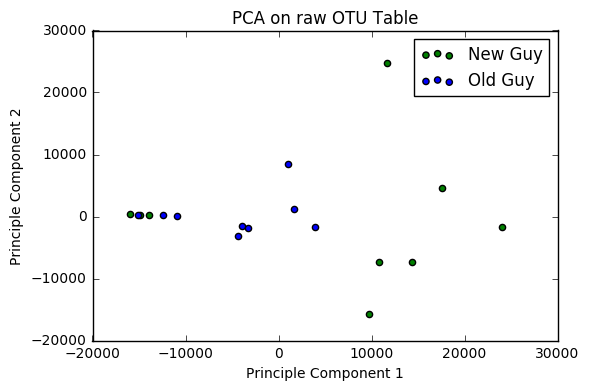

In [500]:
plt.subplot()
plt.scatter(final[:9, 0], final[:9,1], c = 'g', label = 'New Guy')
plt.scatter(final[9:, 0], final[9:,1], c = 'b', label = 'Old Guy')
plt.legend(loc='upper right')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('PCA on raw OTU Table')

#plt.scatter?
plt.show()


### Transform Data by Beta Diversity Index (Bray-Curtis)

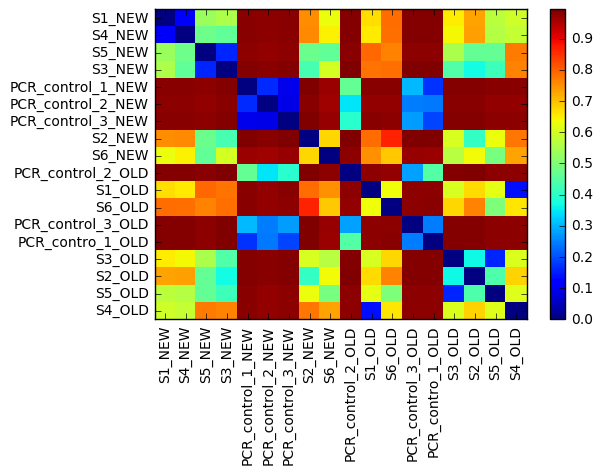

In [294]:
bray = beta_diversity('braycurtis', counts = df_bare, ids=ids)

bray

In [501]:
pca2 = PCA(n_components=2)
final2 = pca2.fit_transform(bray.data)
final2

array([[-0.79884321,  0.18464609],
       [-0.83320206,  0.14130716],
       [-0.95097597, -0.54587477],
       [-1.00346657, -0.57865153],
       [ 1.66222459, -0.06036819],
       [ 1.67931792, -0.06399211],
       [ 1.70604791, -0.0681221 ],
       [-0.71279526, -0.44314519],
       [-0.70931657, -0.11561199],
       [ 1.39830879,  0.02200559],
       [-0.63716785,  0.86497384],
       [-0.48475676,  0.48046919],
       [ 1.59868176, -0.03301893],
       [ 1.62464073, -0.04754525],
       [-0.96207653, -0.12336963],
       [-0.89005065, -0.36097828],
       [-1.01638835, -0.10327806],
       [-0.67018191,  0.85055414]])

In [344]:
final2


x = final2[:, 0]
y = final2[:, 1]

df_meta['x'] = x
df_meta['y'] = y

df_meta

,Tech,Sample Name,Sample ID,Sample Name Colors,Sample ID Colors,x,y
0,New Guy,S1_NEW,S1,Green,red,-0.798843,0.184646
1,New Guy,S4_NEW,S4,Green,blue,-0.833202,0.141307
2,New Guy,S5_NEW,S5,Green,orange,-0.950976,-0.545875
3,New Guy,S3_NEW,S3,Green,yellow,-1.003467,-0.578652
4,New Guy,PCR_control_1_NEW,Control,Green,brown,1.662225,-0.060368
5,New Guy,PCR_control_2_NEW,Control,Green,brown,1.679318,-0.063992
6,New Guy,PCR_control_3_NEW,Control,Green,brown,1.706048,-0.068122
7,New Guy,S2_NEW,S2,Green,purple,-0.712795,-0.443145
8,New Guy,S6_NEW,S6,Green,green,-0.709317,-0.115612
9,Old Guy,PCR_control_2_OLD,Control,Blue,brown,1.398309,0.022006


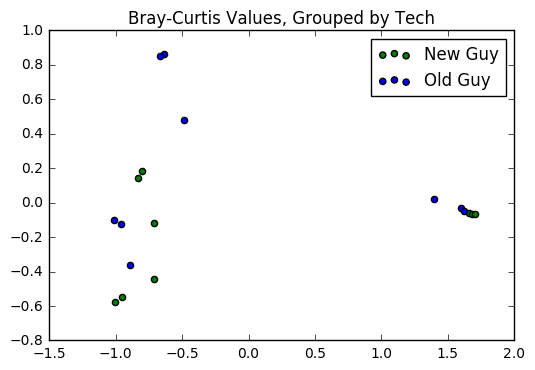

In [524]:
plt.subplot()
#a= plt.scatter(df_meta['x'], df_meta['y'], c= df_meta['Sample Name Colors'], label = df_meta['Tech'])

plt.scatter(df_meta['x'][:9], df_meta['y'][:9], c = 'g', label= 'New Guy')
plt.scatter(df_meta['x'][9:], df_meta['y'][9:], c = 'b', label= 'Old Guy')
plt.title("Bray-Curtis Values, Grouped by Tech")
plt.legend()
plt.xlabel("")
plt.show()

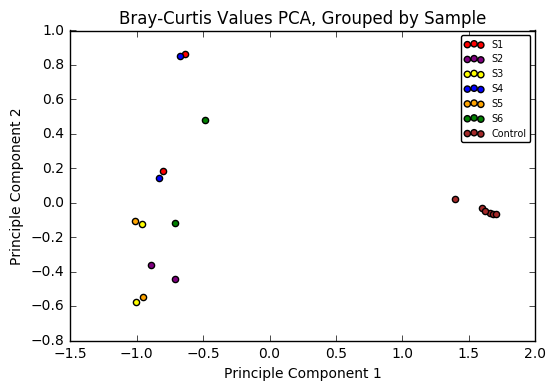

In [525]:
plt.figure()
#plt.scatter(final2[:, 0], final2[:,1], c= df_meta['Sample ID Colors'], label = df_meta['Sample ID'])

# S1
plt.scatter(df_meta['x'].loc[df_meta['Sample ID'] == 'S1'], 
            df_meta['y'].loc[df_meta['Sample ID'] == 'S1'], label = 'S1', c= 'red')

# S2
plt.scatter(df_meta['x'].loc[df_meta['Sample ID'] == 'S2'], 
            df_meta['y'].loc[df_meta['Sample ID'] == 'S2'], label= 'S2', c= 'Purple')

#S3
plt.scatter(df_meta['x'].loc[df_meta['Sample ID'] == 'S3'], 
            df_meta['y'].loc[df_meta['Sample ID'] == 'S3'], label= 'S3', c= 'Yellow')

#S4
plt.scatter(df_meta['x'].loc[df_meta['Sample ID'] == 'S4'], 
            df_meta['y'].loc[df_meta['Sample ID'] == 'S4'], label= 'S4', c= 'Blue')

#S5
plt.scatter(df_meta['x'].loc[df_meta['Sample ID'] == 'S5'], 
            df_meta['y'].loc[df_meta['Sample ID'] == 'S5'], label= 'S5', c= 'Orange')

#S6
plt.scatter(df_meta['x'].loc[df_meta['Sample ID'] == 'S6'], 
            df_meta['y'].loc[df_meta['Sample ID'] == 'S6'], label= 'S6', c= 'Green')

#S7
plt.scatter(df_meta['x'].loc[df_meta['Sample ID'] == 'Control'], 
            df_meta['y'].loc[df_meta['Sample ID'] == 'Control'], label= 'Control', c= 'Brown')





plt.legend(fancybox = True, loc= 'upper right', fontsize = 'x-small')
plt.title("Bray-Curtis Values PCA, Grouped by Sample")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")


plt.show()

# GUESS THE TECH

In [539]:
#instantiate the model
KM = KMeans(n_clusters=2)
#
pred = KM.fit_predict(X=df_bare)

# create label, 0 = new guy, 1 = old guy
labels = [0] * 9
labels.extend([1] * 9)


sklearn.metrics.accuracy_score(labels_tech, pred)

0.16666666666666666

In [537]:
value_df = []
for x in range(0, 200):
    pred = KM.fit_predict(X=df_bare)
    value = sklearn.metrics.accuracy_score(labels_tech, pred)
    value_df.append(value)
    
    

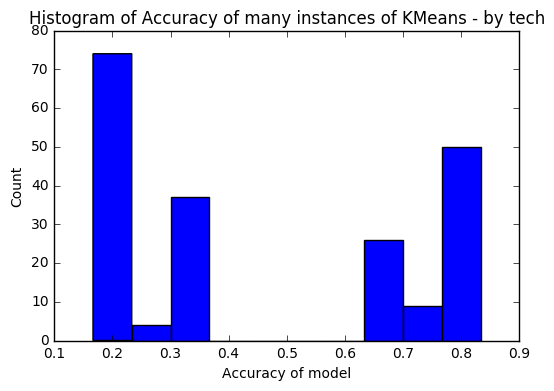

In [506]:
plt.figure()
plt.hist(value_df)
plt.title('Histogram of Accuracy of many instances of KMeans - by tech')
plt.xlabel('Accuracy of model')
plt.ylabel('Count')
plt.show()

# Guess the Sample

In [308]:
sample_id_map = {'S1': 0, 'S4': 1, 'S3': 2,
                 'Control': 3, 'S2': 4, 'S5': 5,
                'S6': 6}

In [438]:
labels_tech = labels


labels_id = df_meta['Sample ID'].map(sample_id_map)
labels_id

0     0
1     1
2     5
3     2
4     3
5     3
6     3
7     4
8     6
9     3
10    0
11    6
12    3
13    3
14    2
15    4
16    5
17    1
Name: Sample ID, dtype: int64

In [533]:
# instantiate the model
KM = KMeans(n_clusters=7)

In [535]:


# train and predict!
pred = KM.fit_predict(X=df_bare)

# print accuracy score
sklearn.metrics.accuracy_score(labels_id, pred)


0.1111111111111111

In [522]:
# do the KM 200 times, save to list
value_df = []
for x in range(0, 200):
    pred = KM.fit_predict(X=df_bare)
    value = sklearn.metrics.accuracy_score(labels_tech, pred)
    value_df.append(value)

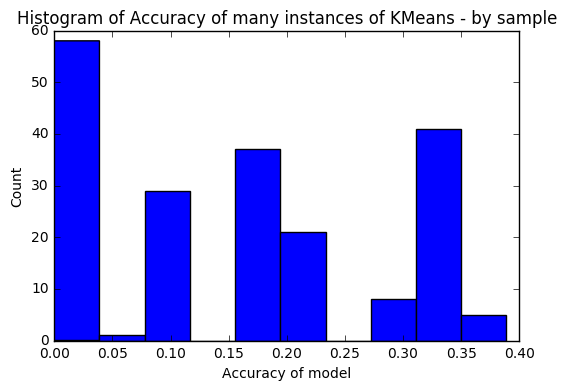

In [523]:
# histogram of accuracy score
plt.figure()
plt.hist(value_df)
plt.title('Histogram of Accuracy of many instances of KMeans - by sample')
plt.xlabel('Accuracy of model')
plt.ylabel('Count')
plt.show()

In [304]:
# group by TECH
permanova(distance_matrix=bray, grouping=labels)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      18
number of groups                  2
test statistic              1.24944
p-value                       0.181
number of permutations          999
Name: PERMANOVA results, dtype: object

In [311]:
# group by SAMPLE
permanova(distance_matrix=bray, grouping=labels_id)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      18
number of groups                  7
test statistic              6.80356
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object